In [155]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ctapipe.io import EventSourceFactory
# from ctapipe.instrument import get_atmosphere_profile_functions

%matplotlib inline

names_to_id = {'LSTCam': 1, 'NectarCam': 2, 'FlashCam': 3, 'DigiCam': 4, 'CHEC': 5}
types_to_id = {'LST': 1, 'MST': 2, 'SST': 3}
allowed_cameras = ['LSTCam', 'NectarCam', 'DigiCam']

In [161]:
event_source = EventSourceFactory.produce(
    input_url='../gamma_20deg_0deg_run501___cta-prod3-merged_desert-2150m-Paranal-3HB89-NGFD.simtel.gz',
    product='HESSIOEventSource',
)
thickness, altitude = get_atmosphere_profile_functions('paranal')

event = next(iter(event_source))
telescope_positions = []
ids = event.inst.subarray.tel.keys()
for i in list(ids):
    if event.inst.subarray.tels[i].camera.cam_id in allowed_cameras:
        telescope_positions.append(event.inst.subarray.positions[i].value)

telescope_positions = np.vstack(telescope_positions)

In [6]:
#create some direction vectors

uvw_vectors = np.array([[ 0.31525132,  0.02614854,  0.94864791],
 [ 0.34933397 , 0.01623957,  0.93685754],
 [ 0.31831154 , 0.02024308 , 0.94777001],
 [ 0.33122497 , 0.02375038 , 0.94325285],
 [ 0.32213274 , 0.00652958 , 0.94667199],
 [ 0.33212182 ,-0.01708339 , 0.94308179],
 [ 0.33542324 , 0.01243472 , 0.94198547],
 [ 0.3416002 , -0.01224679,  0.93976557]])

normalize_uvw_vectors = uvw_vectors / np.linalg.norm(uvw_vectors, axis=1)[:, np.newaxis]
normalize_uvw_vectors

array([[ 0.31525132,  0.02614854,  0.94864791],
       [ 0.34933397,  0.01623957,  0.93685754],
       [ 0.31831154,  0.02024308,  0.94777   ],
       [ 0.33122497,  0.02375038,  0.94325285],
       [ 0.32213274,  0.00652958,  0.94667199],
       [ 0.33212182, -0.01708339,  0.94308179],
       [ 0.33542324,  0.01243472,  0.94198547],
       [ 0.3416002 , -0.01224679,  0.93976557]])

In [7]:
np.rad2deg(np.arccos(uvw_vectors[0]@uvw_vectors[5]))

2.6782249078322593

In [10]:
def lstsqr_intersection(uvw_vectors, telescope_positions):
    C = []
    for n, pos in zip(uvw_vectors, telescope_positions):
        n = n.reshape((3, 1))
        C.append((n@n.T - np.eye(3))@pos)    
    C = np.array(C).sum(axis=0)

    S = []
    for n in uvw_vectors:
        n = n.reshape((3, 1))
        S.append(n@n.T - np.eye(3))
    S = np.array(S).sum(axis=0)

    return np.linalg.inv(S)@C

lstsqr_intersection(normalize_uvw_vectors, positions)

array([-1238.64309514,  -204.90553065, -2744.60218491])

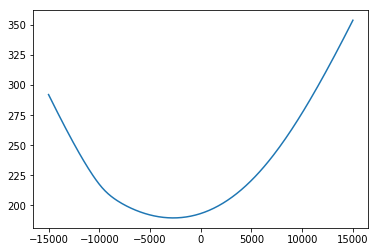

In [170]:
# https://en.wikipedia.org/wiki/Line%E2%80%93plane_intersection

def minimize_intersection_with_plane(z, uvw_vectors, positions):
    n = np.array([0, 0, 1])
    p_0 = np.array([0, 0, z])
    intersection_points = []
    for direction, pos in zip(uvw_vectors, positions):
        l_0 = pos
        l = direction
        d = ((p_0 - l_0) @ n) / (l@n)
        intersection_points.append(d * l + l_0)
    
    intersection_points = np.vstack(intersection_points)
    mean_intersection = intersection_points.mean(axis=0)
    
    f = np.linalg.norm(intersection_points - mean_intersection, axis=1).mean()
    return f

f = np.vectorize(minimize_intersection_with_plane, excluded=[1, 2])
zs = np.linspace(-15000, 15000, 200)
plt.plot(zs, f(zs, normalize_uvw_vectors, positions, ))

In [163]:
minimize_scalar?

In [165]:
from scipy.optimize import minimize_scalar

estimated_max_height = minimize_scalar(f, args=(normalize_uvw_vectors, positions)).x
estimated_max_height

f(estimated_max_height, normalize_uvw_vectors, positions)

array(189.59987634)

In [148]:
b = np.vstack(a).mean(axis=0)
np.linalg.norm(b - a, axis=1).mean()

251.3010364737758

In [171]:
np.array([1, 2, 3]) @ np.array([3, 4, 5])

26

(-4000, 4000)

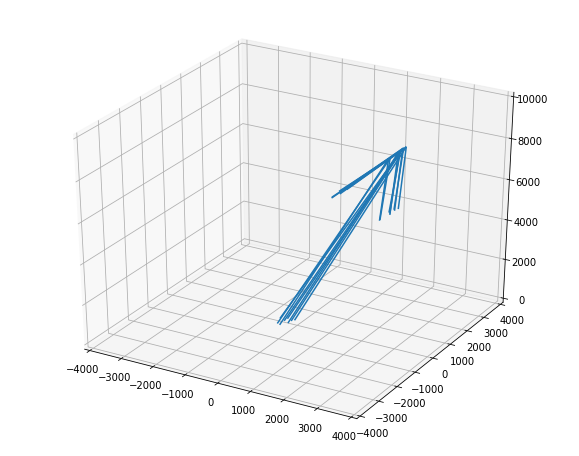

In [172]:

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
a = uvw_vectors*10000
ax.quiver(positions[:, 0], positions[:, 1], positions[:, 2], a[:, 0], a[:, 1], a[:, 2])
# ax.scatter(*T, color='red',  s=500)
ax.set_zlim([0, 10000])
ax.set_ylim([-4000, 4000])
ax.set_xlim([-4000, 4000])


In [174]:
def fit_h_max(self, hillas_dict, subarray, pointing_alt, pointing_az):
    os = []
    ns = []

    for tel_id, moments in hillas_dict.items():
        # weights.append(self.hillas_planes[tel_id].weight)
        pos = self.hillas_planes[tel_id].pos
        os.append(pos)
        dir = self.hillas_planes[tel_id].a
        ns.append(dir)

    os = np.array(os)
    ns = np.array(ns)
    print(ns)
    print(os)

    c = []
    for n, a in zip(ns, os):
        n = n.reshape((3, 1))
        c.append((n@n.T - np.eye(3))@a)

    c = np.array(c).sum(axis=0)

    S = []
    for n in ns:
        n = n.reshape((3, 1))
        S.append(n@n.T - np.eye(3))

    S = np.array(S).sum(axis=0)
    print(np.linalg.cond(S))
    p = np.linalg.inv(S)@c
    return p[2]